In [1]:
!pip install pyts

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 32.8 MB/s eta 0:00:0000:0100:01


In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import ImageGrid
from pyts.image import GramianAngularField
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

def root_directory():
    """Returns the root directory of the project."""
    return "/kaggle/input/swell-heart-rate-variability-hrv/hrv dataset"

def data_directory():
    """Returns the data directory path."""
    return os.path.join(root_directory(), "data")
    
def load_train_set():
    """Loads training dataset as a Pandas DataFrame."""
    train_file = os.path.join(data_directory(), "final", "train.csv")
    return pd.read_csv(train_file)

def load_test_set():
    """Loads test dataset as a Pandas DataFrame."""
    test_file = os.path.join(data_directory(), "final", "test.csv")
    return pd.read_csv(test_file)

train = load_train_set()
test = load_test_set()

target = "condition"

hrv_features = [col for col in train.columns if col != target]

label_map = {"no stress": 0, "interruption":1, "time pressure": 2}
train[target] = train[target].map(label_map)
test[target] = test[target].map(label_map)


def sample_data(df, label_col, n_samples):
    """Safely sample n_samples per class without errors."""
    sampled_df = []
    for label in df[label_col].unique():
        class_data = df[df[label_col] == label]
        sample_size = min(n_samples, len(class_data))  
        sampled_df.append(class_data.sample(n=sample_size, random_state=42))
    return pd.concat(sampled_df).reset_index(drop=True)

train_balanced = sample_data(train, target, 10000)
test_balanced = sample_data(test, target, 3000)  

X_train = train_balanced[hrv_features]
y_train = train_balanced[target]

if "datasetId" in X_train.columns:
    X_train = X_train.drop(columns="datasetId")

X_test = test_balanced[hrv_features]
y_test = test_balanced[target]

if "datasetId" in X_test.columns:
    X_test = X_test.drop(columns="datasetId")

print(f"Train Set Shape: {X_train.shape}, Labels Shape: {y_train.shape}")
print(f"Test Set Shape: {X_test.shape}, Labels Shape: {y_test.shape}")

display(X_train.head())
display(y_train.head())

Train Set Shape: (30000, 34), Labels Shape: (30000,)
Test Set Shape: (9000, 34), Labels Shape: (9000,)


,MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,HR,pNN25,pNN50,SD1,...,LF_PCT,LF_NU,HF,HF_PCT,HF_NU,TP,LF_HF,HF_LF,sampen,higuci
0,896.720876,880.459590,106.101117,13.924951,13.924949,7.619497,67.818401,7.733333,0.466667,9.849712,...,28.035932,98.809256,9.922258,0.337859,1.190744,2936.803667,82.981135,0.012051,2.127076,1.134921
1,903.325242,905.495460,72.285411,12.387407,12.386563,5.835395,66.855229,4.466667,0.133333,8.761546,...,23.244445,99.726832,1.783522,0.063670,0.273168,2801.178306,365.074431,0.002739,2.192351,1.069071
2,934.870026,916.307545,128.556268,16.728592,16.728579,7.684823,65.364253,13.200000,1.066667,11.832839,...,28.280122,99.507931,6.164162,0.139846,0.492069,4407.828115,202.223606,0.004945,2.160318,1.126186
3,726.048217,726.396200,58.167902,9.760850,9.760850,5.959307,83.181060,1.400000,0.000000,6.904267,...,22.022647,93.990424,26.015607,1.408088,6.009576,1847.584044,15.640109,0.063938,2.157452,1.152640
4,903.212333,918.237180,108.998652,16.905228,16.905228,6.447630,67.479959,12.400000,1.333333,11.957790,...,23.825552,98.769012,13.625402,0.296945,1.230988,4588.526989,80.235569,0.012463,2.179244,1.177820


0    0
1    0
2    0
3    0
4    0
Name: condition, dtype: int64

In [4]:
def quantile_normalize(df):
    """Applies quantile normalization to the DataFrame."""
    df_sorted = pd.DataFrame(np.sort(df.values, axis=0), index=df.index, columns=df.columns)
    df_mean = df_sorted.mean(axis=1)
    df_mean.index = np.arange(1, len(df_mean) + 1)
    df_qn = df.rank(method="min").stack().astype(int).map(df_mean).unstack()
    return df_qn

x_train_swell = quantile_normalize(X_train)
x_test_swell = quantile_normalize(X_test)

display(x_train_swell.head())
display(x_test_swell.head())
print(x_train_swell.describe())
print(x_test_swell.describe())

,MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,HR,pNN25,pNN50,SD1,...,LF_PCT,LF_NU,HF,HF_PCT,HF_NU,TP,LF_HF,HF_LF,sampen,higuci
0,276.697101,261.548330,281.634094,201.939225,201.948873,306.099269,186.792253,220.098299,219.751609,201.948873,...,209.281585,309.383929,166.989622,170.844721,172.502720,229.176610,309.383929,172.502720,220.280335,160.774105
1,283.060633,290.437894,183.073989,167.021640,166.952993,215.238532,178.099179,165.854182,166.058400,166.952993,...,175.512435,527.319177,104.591577,111.702021,111.394438,220.181001,527.319177,111.394438,390.664047,91.473882
2,312.856441,298.311570,333.659979,277.912510,277.935225,309.649467,167.908511,315.431057,277.893149,277.935225,...,211.163474,434.164037,141.753598,139.078646,129.723889,339.437487,434.164037,129.723889,264.643133,147.015168
3,118.124366,124.548167,136.809099,117.415260,117.430190,221.768654,463.050505,112.676927,57.594885,117.430190,...,165.622387,158.516499,250.212396,280.129440,339.707893,158.679659,158.516499,339.707893,259.802904,193.893174
4,282.869530,300.263695,289.169845,283.041251,283.046942,248.500700,183.634928,300.234227,309.342415,283.046942,...,179.713401,305.818680,184.847490,165.565337,174.383861,355.878824,305.818680,174.383861,315.449174,240.393451


,MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,HR,pNN25,pNN50,SD1,...,LF_PCT,LF_NU,HF,HF_PCT,HF_NU,TP,LF_HF,HF_LF,sampen,higuci
0,154.981903,130.948799,357.917964,218.603896,218.603896,399.488499,376.844594,226.243094,239.203434,218.603896,...,181.232421,142.039242,396.002894,311.944479,386.663115,242.885987,142.039242,386.663115,94.875043,272.298257
1,206.332670,212.064032,158.559158,158.894224,158.894224,188.846044,240.684831,152.445046,58.596835,158.894224,...,190.435567,171.716120,259.323638,280.144485,306.319210,163.331167,171.716120,306.319210,250.749993,301.416603
2,108.774609,110.761248,174.510012,123.887169,123.887169,272.919928,513.057777,134.679136,58.596835,123.887169,...,207.303791,223.802244,209.252014,228.533895,232.983896,175.664416,223.802244,232.983896,297.822034,161.413623
3,184.635339,206.397936,343.041840,204.879360,204.879360,387.853716,305.771471,206.484818,278.290686,204.879360,...,166.258531,211.404028,272.407888,219.344145,244.743676,281.113670,211.404028,244.743676,194.813778,174.500443
4,173.729083,170.568761,115.378578,158.499353,158.499353,143.334814,289.746416,143.353928,58.596835,158.499353,...,522.481666,276.389324,196.987243,244.559104,188.324377,140.363456,276.389324,188.324377,267.048739,166.388660


            MEAN_RR     MEDIAN_RR          SDRR         RMSSD          SDSD  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean     272.534334    272.434753    272.534334    272.534334    272.534334   
std      161.064480    160.681748    161.064480    161.064480    161.064480   
min       57.594885     57.594885     57.594885     57.594885     57.594885   
25%      161.769849    161.769849    161.769849    161.769849    161.769849   
50%      229.496375    229.489324    229.496375    229.496375    229.496375   
75%      332.274137    332.242212    332.274137    332.274137    332.274137   
max     1242.394745   1144.375092   1242.394745   1242.394745   1242.394745   

         SDRR_RMSSD            HR         pNN25         pNN50           SD1  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean     272.534334    272.534334    271.779447    253.502644    272.534334   
std      161.064480    161.064480    160.934737    

In [5]:
gaf = GramianAngularField()

X_train_gaf = gaf.fit_transform(X_train.to_numpy())
X_test_gaf = gaf.fit_transform(X_test.to_numpy())

X_train_gaf = X_train_gaf.reshape(X_train_gaf.shape[0], 34, 34, 1)
X_test_gaf = X_test_gaf.reshape(X_test_gaf.shape[0], 34, 34, 1)

X_train_gaf /= np.max(X_train_gaf, axis=(1, 2, 3), keepdims=True)
X_test_gaf /= np.max(X_test_gaf, axis=(1, 2, 3), keepdims=True)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)
print(X_train_gaf.shape)
print(X_test_gaf.shape)
print(y_train.shape)
print(y_test.shape)

(30000, 34, 34, 1)
(9000, 34, 34, 1)
(30000, 3)
(9000, 3)


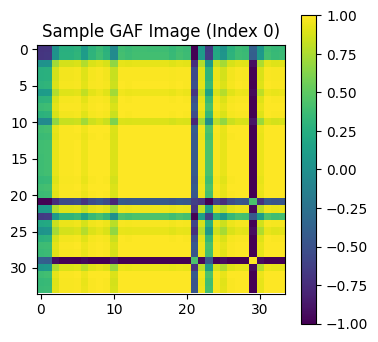

In [6]:
import matplotlib.pyplot as plt

sample_idx = 0  

sample_gaf_image = X_train_gaf[sample_idx, :, :, 0]  

plt.figure(figsize=(4, 4))
plt.imshow(sample_gaf_image, cmap='viridis')  
plt.colorbar()
plt.title(f"Sample GAF Image (Index {sample_idx})")
plt.show()

In [7]:
import tensorflow as tf
from tensorflow.keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers, callbacks

# Define the Model with Swish Activation
model_CNN = tf.keras.Sequential([
    layers.Conv2D(32, (3,3), padding="same", kernel_regularizer=regularizers.l2(1e-6), input_shape=(34, 34, 1)),
    layers.BatchNormalization(),
    layers.Activation('swish'),  
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3,3), padding="same", kernel_regularizer=regularizers.l2(1e-6)),
    layers.BatchNormalization(),
    layers.Activation('swish'),  
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3,3), padding="same", kernel_regularizer=regularizers.l2(1e-6)),  
    layers.BatchNormalization(),
    layers.Activation('swish'),  
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(64, activation='swish', kernel_regularizer=regularizers.l2(1e-6)), 
    layers.BatchNormalization(),

    layers.Dense(3, activation='softmax')
])

loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model_CNN.compile(optimizer=optimizer, 
                  loss=loss, 
                  metrics=['accuracy', f1_m, precision_m, recall_m])
model_CNN.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 34, 34, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 34, 34, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 34, 34, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 17, 17, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 17, 17, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 17, 17, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225,155 (879.51 KB)

 Trainable params: 224,579 (877.26 KB)

 Non-trainable params: 576 (2.25 KB)

In [12]:
model_checkpoint = callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_loss', verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

history = model_CNN.fit(
    X_train_gaf, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_gaf, y_test),
    callbacks=[ model_checkpoint, reduce_lr]
)

Epoch 1/50
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5105 - f1_m: 0.3915 - loss: 1.0249 - precision_m: 0.6055 - recall_m: 0.2995
Epoch 1: val_loss improved from inf to 1.03269, saving model to best_model.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 75s 72ms/step - accuracy: 0.5106 - f1_m: 0.3916 - loss: 1.0248 - precision_m: 0.6056 - recall_m: 0.2997 - val_accuracy: 0.5396 - val_f1_m: 0.5001 - val_loss: 1.0327 - val_precision_m: 0.5451 - val_recall_m: 0.4705 - learning_rate: 0.0010
Epoch 2/50
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6535 - f1_m: 0.6062 - loss: 0.8421 - precision_m: 0.7251 - recall_m: 0.5244
Epoch 2: val_loss improved from 1.03269 to 0.91289, saving model to best_model.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 70s 74ms/step - accuracy: 0.6536 - f1_m: 0.6063 - loss: 0.8421 - precision_m: 0.7251 - recall_m: 0.5245 - val_accuracy: 0.6359 - val_f1_m: 0.5887 - val_loss: 0.9129 - val_precision_m: 0.6518 - val_recall_m: 0.5423 - learning_rate: 0.0010
Epoch 3/50
937

In [13]:
loss, accuracy, f1_score, precision, recall = model_CNN.evaluate(X_test_gaf, y_test, verbose=0)
print(f"Validation Loss: {loss}")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1_score}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Validation Loss: 0.32627126574516296
Accuracy: 0.9946666955947876
F1 Score: 0.9944291114807129
Precision: 0.9956637024879456
Recall: 0.993240237236023


**Visualizations**

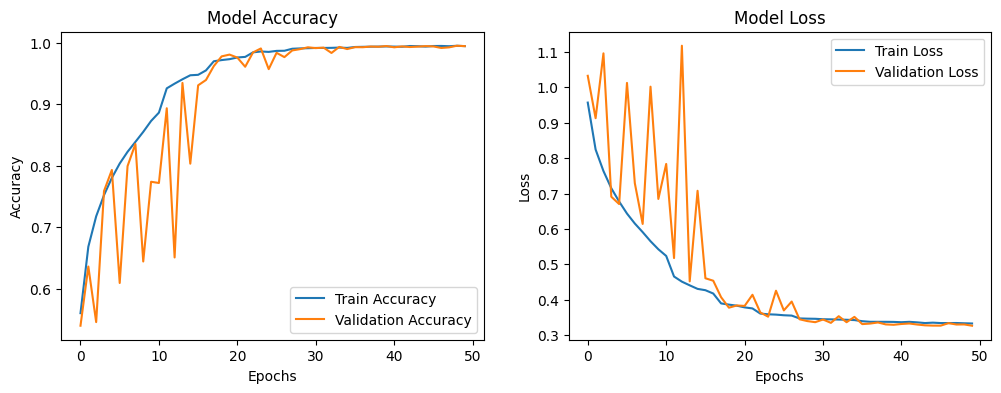

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
import numpy as np
from itertools import cycle

def plot_accuracy_loss(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    axs[0].plot(history.history['accuracy'], label='Train Accuracy')
    axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[0].set_title('Model Accuracy')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()

    axs[1].plot(history.history['loss'], label='Train Loss')
    axs[1].plot(history.history['val_loss'], label='Validation Loss')
    axs[1].set_title('Model Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    plt.show()
    
plot_accuracy_loss(history)

282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step


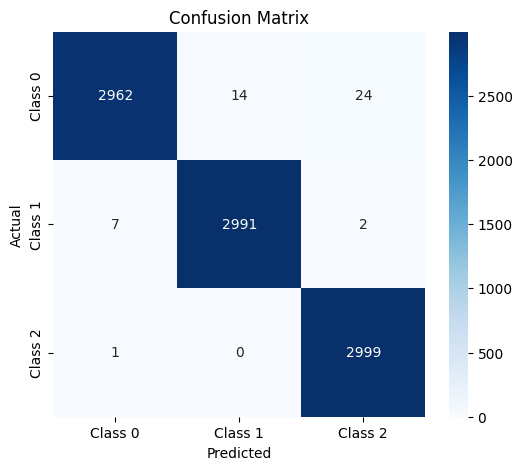

In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(model, x_test, y_test):
    y_pred = np.argmax(model.predict(x_test), axis=1)
    y_true = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    class_names = [f'Class {i}' for i in range(y_test.shape[1])]
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(model_CNN, X_test_gaf, y_test)

282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step


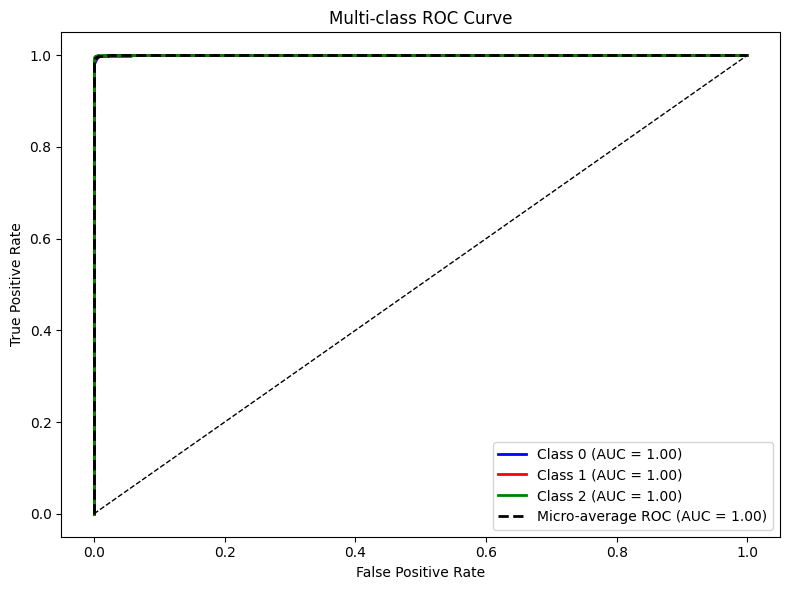

In [16]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle
import matplotlib.pyplot as plt

def plot_roc_curve(model, x_test, y_test):
    y_pred = model.predict(x_test)
    n_classes = y_test.shape[1]

    fpr, tpr, roc_auc = {}, {}, {}
    plt.figure(figsize=(8, 6))
    colors = cycle(['blue', 'red', 'green', 'purple', 'orange'])

    for i, color in zip(range(n_classes), colors):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.2f})',
             color='black', linestyle='--', linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
    
plot_roc_curve(model_CNN, X_test_gaf, y_test)

282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 19

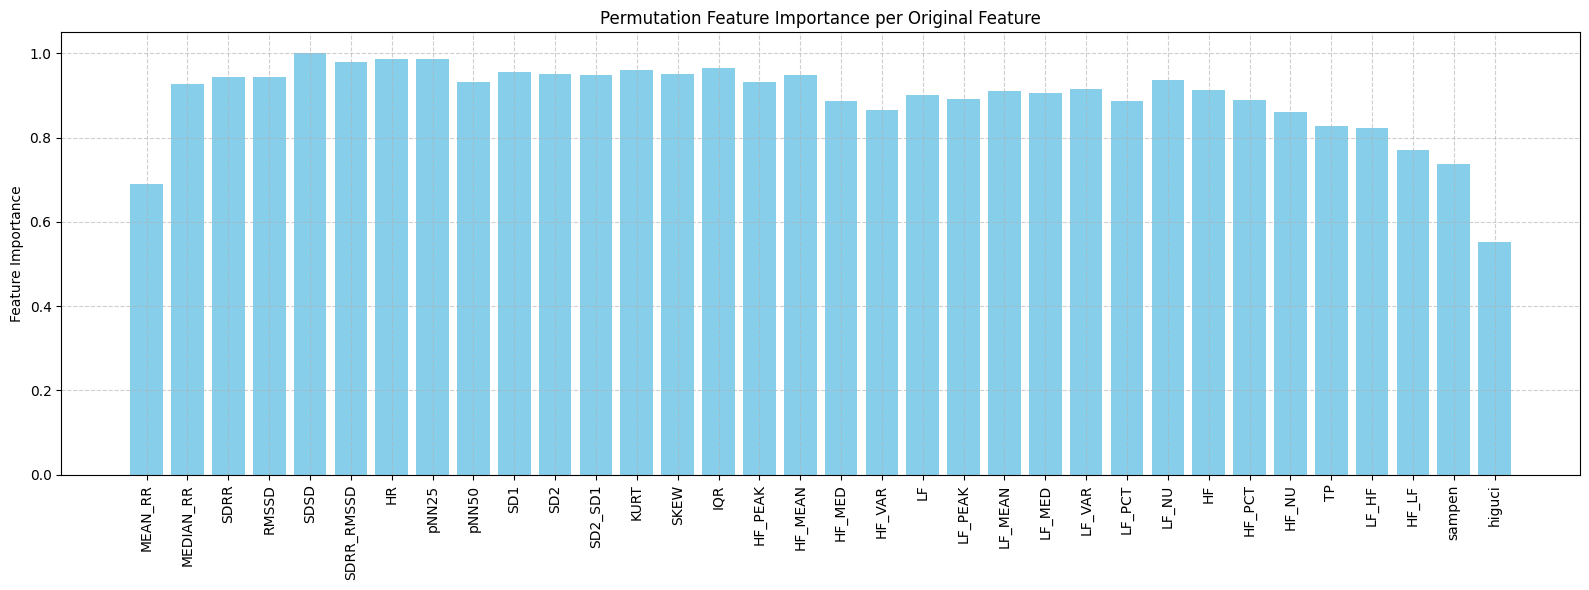

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

def permutation_importance_gaf(model, X, y_true, base_score_fn=accuracy_score):
    """
    Computes permutation importance for GAF input of shape (N, 34, 34).
    Permutes both row and column i for each of the 34 original features.
    """
    base_preds = np.argmax(model.predict(X), axis=1)
    if len(y_true.shape) > 1:
        y_true = np.argmax(y_true, axis=1)

    base_score = base_score_fn(y_true, base_preds)
    feature_importance = []

    for i in range(34):  
        X_permuted = np.copy(X)

        for j in range(X.shape[0]):  
            perm = np.random.permutation(X.shape[1])
            X_permuted[j, i, :] = X_permuted[j, i, perm]  
            X_permuted[j, :, i] = X_permuted[j, perm, i]  

        preds = np.argmax(model.predict(X_permuted), axis=1)
        score = base_score_fn(y_true, preds)
        importance = base_score - score
        feature_importance.append(importance)

    return feature_importance                                                                                                                                                                                                                                      # Feature names (ensure this matches your original 34 features)
feature_names = [
    "MEAN_RR", "MEDIAN_RR", "SDRR", "RMSSD", "SDSD", "SDRR_RMSSD", "HR", 
    "pNN25", "pNN50", "SD1", "SD2", "SD2_SD1", "KURT", "SKEW", "IQR", 
    "HF_PEAK", "HF_MEAN", "HF_MED", "HF_VAR", "LF", "LF_PEAK", "LF_MEAN", 
    "LF_MED", "LF_VAR", "LF_PCT", "LF_NU", "HF", "HF_PCT", "HF_NU", "TP", 
    "LF_HF", "HF_LF", "sampen", "higuci"
]

importance_per_feature = permutation_importance_gaf(model_CNN, X_test_gaf, y_test)
importance_per_feature = np.array(importance_per_feature)
importance_per_feature /= importance_per_feature.max()
plt.figure(figsize=(16, 6))
plt.bar(range(34), importance_per_feature, color='skyblue')
plt.xticks(range(34), feature_names, rotation=90)
plt.ylabel("Feature Importance")
plt.title("Permutation Feature Importance per Original Feature")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()